In [ ]:
import requests
import tarfile
import os

url = "http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.tar.gz"
output_path = "/content/news20.tar.gz"
extract_path = "/content/20_newsgroups"


print(f"Downloading {url}...")
try:
    response = requests.get(url, stream=True)
    response.raise_for_status()
    with open(output_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print("Download complete.")


    print(f"Extracting {output_path} to {extract_path}...")
    with tarfile.open(output_path, 'r:gz') as tar:
        tar.extractall(path=extract_path)
    print("Extraction complete.")


    print("\nExtracted directories:")
    print(os.listdir(extract_path))

except requests.exceptions.RequestException as e:
    print(f"Error during download: {e}")
except tarfile.TarError as e:
    print(f"Error during extraction: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Download complete.
Extracting /content/news20.tar.gz to /content/20_newsgroups...


/tmp/ipython-input-1006043854.py:22: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_path)


Extraction complete.

Extracted directories:
['20_newsgroup']


In [ ]:
import os

dataset_path = "/content/20_newsgroups/20_newsgroup"
data = []
labels = []


for newsgroup in os.listdir(dataset_path):
    newsgroup_path = os.path.join(dataset_path, newsgroup)
    if os.path.isdir(newsgroup_path):

        for filename in os.listdir(newsgroup_path):
            filepath = os.path.join(newsgroup_path, filename)
            try:
                with open(filepath, 'r', errors='ignore') as f:
                    text = f.read()
                data.append(text)
                labels.append(newsgroup)
            except Exception as e:
                print(f"Error reading file {filepath}: {e}")

print(f"Loaded {len(data)} documents from the 20 newsgroups dataset.")
print("First 5 labels:", labels[:5])

Loaded 19997 documents from the 20 newsgroups dataset.
First 5 labels: ['comp.graphics', 'comp.graphics', 'comp.graphics', 'comp.graphics', 'comp.graphics']


In [ ]:
def extract_features(text):


  lowercase_text = text.lower()


  words = lowercase_text.split()


  feature_dict = {}
  for word in words:

    cleaned_word = ''.join(filter(str.isalnum, word))
    if cleaned_word:
      feature_dict[cleaned_word] = feature_dict.get(cleaned_word, 0) + 1


  return feature_dict


sample_text = "The quick brown fox jumps over the lazy dog. The dog is lazy."
features = extract_features(sample_text)
print(features)

{'the': 3, 'quick': 1, 'brown': 1, 'fox': 1, 'jumps': 1, 'over': 1, 'lazy': 2, 'dog': 2, 'is': 1}


In [ ]:
feature_data = []
for text in data:
    features = extract_features(text)
    feature_data.append(features)

print(f"Extracted features for {len(feature_data)} documents.")

Extracted features for 19997 documents.


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression

class SimpleLogisticRegression:
    def __init__(self, classes, weights=None):



        self.classes = classes
        self.weights = weights if weights is not None else {}
        self.feature_to_index = {}
        self.index_to_feature = {}
        self._weight_vector = None


        if self.weights:
            features = list(self.weights.keys())
            self.feature_to_index = {feature: i for i, feature in enumerate(features)}
            self.index_to_feature = {i: feature for i, feature in enumerate(features)}
            self._weight_vector = np.array([self.weights[feature] for feature in features], dtype=np.float64)
        else:
             self._weight_vector = np.array([], dtype=np.float64)


    def _get_feature_index(self, feature):


        if feature not in self.feature_to_index:
            index = len(self.feature_to_index)
            self.feature_to_index[feature] = index
            self.index_to_feature[index] = feature

            if self._weight_vector is None:
                self._weight_vector = np.zeros(1, dtype=np.float64)
            else:
                self._weight_vector = np.pad(self._weight_vector, (0, 1), 'constant')

            self._weight_vector[index] = self.weights.get(feature, 0)
        return self.feature_to_index[feature]

    def _score(self, feature_dict):


        score = 0
        for feature, value in feature_dict.items():
            if feature in self.feature_to_index:
                 score += self._weight_vector[self.feature_to_index[feature]] * value
        return score

    def predict_proba(self, feature_dict):



        for feature in feature_dict.keys():
             self._get_feature_index(feature)

        score_positive_class = self._score(feature_dict)
        prob_positive = 1 / (1 + np.exp(-score_positive_class))


        prob_negative = 1 - prob_positive
        prob_positive = prob_positive

        probabilities = {self.classes[0]: prob_negative, self.classes[1]: prob_positive}

        return probabilities

    def get_weights(self):


        return {self.index_to_feature[i]: weight for i, weight in enumerate(self._weight_vector)}

    def set_weights(self, weights_dict):


        for feature in weights_dict.keys():
            self._get_feature_index(feature)


        for feature, weight in weights_dict.items():
            if feature in self.feature_to_index:
                self._weight_vector[self.feature_to_index[feature]] = weight

In [ ]:
import numpy as np


class Constraint:
    def __init__(self, word, label, expected_value):



        self.word = word
        self.label = label
        self.expected_value = expected_value



    pass



def feature_function(feature_dict, label, constraint_word, target_label):


    if label == target_label:
        return feature_dict.get(constraint_word, 0)
    else:
        return 0



def evaluate_constraint(constraint, model, dataset):



    calculated_expected_value = 0
    for feature_dict in dataset:


        predicted_probs = model.predict_proba(feature_dict)
        target_label_prob = predicted_probs.get(constraint.label, 0)


        feature_value_at_target_label = feature_function(
            feature_dict,
            constraint.label,
            constraint.word,
            constraint.label
        )


        calculated_expected_value += target_label_prob * feature_value_at_target_label


    constraint_violation = calculated_expected_value - constraint.expected_value

    return constraint_violation

In [ ]:
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # Import evaluation metrics

class Constraint:
    def __init__(self, word, label, expected_value):
        self.word = word
        self.label = label
        self.expected_value = expected_value

def feature_function(feature_dict, label, constraint_word, target_label):
    if label == target_label:
        return feature_dict.get(constraint_word, 0)
    else:
        return 0

def evaluate_constraint(constraint, model, dataset):
    calculated_expected_value = 0
    for feature_dict in dataset:
        predicted_probs = model.predict_proba(feature_dict)
        target_label_prob = predicted_probs.get(constraint.label, 0)
        feature_value_at_target_label = feature_function(
            feature_dict,
            constraint.label,
            constraint.word,
            constraint.label
        )
        calculated_expected_value += target_label_prob * feature_value_at_target_label
    return calculated_expected_value - constraint.expected_value



def calculate_labeled_data_gradient(model, labeled_data):


    gradient = defaultdict(float)

    positive_class = model.classes[1]

    for feature_dict, label in labeled_data:
        predicted_probs = model.predict_proba(feature_dict)
        p_positive = predicted_probs.get(positive_class, 0)




        indicator_positive = 1 if label == positive_class else 0

        for feature, value in feature_dict.items():

            model._get_feature_index(feature)


            grad_component = - (indicator_positive - p_positive) * value
            gradient[feature] += grad_component


    num_labeled_instances = len(labeled_data) if labeled_data else 1
    for feature in gradient:
        gradient[feature] /= num_labeled_instances

    return dict(gradient)


def calculate_constraint_gradient(constraint, model, dataset_for_constraints):


    gradient = defaultdict(float)
    violation = evaluate_constraint(constraint, model, dataset_for_constraints)

    positive_class_label = model.classes[1]
    negative_class_label = model.classes[0]


    for feature_dict in dataset_for_constraints:
         predicted_probs = model.predict_proba(feature_dict)
         p_positive = predicted_probs.get(positive_class_label, 0)

         f_c_value = feature_function(
             feature_dict,
             constraint.label,
             constraint.word,
             constraint.label
         )


         for feature, value in feature_dict.items():
             if constraint.label == positive_class_label:
                 grad_P_wrt_weight = p_positive * (1 - p_positive) * value
             elif constraint.label == negative_class_label:
                  grad_P_wrt_weight = - p_positive * (1 - p_positive) * value
             else:
                 grad_P_wrt_weight = 0


             grad_E_fc_wrt_weight_from_text = grad_P_wrt_weight * f_c_value


             grad_penalty_from_text = 2 * violation * grad_E_fc_wrt_weight_from_text

             gradient[feature] += grad_penalty_from_text


    num_constraint_instances = len(dataset_for_constraints) if dataset_for_constraints else 1
    for feature in gradient:
        gradient[feature] /= num_constraint_instances


    return dict(gradient)



def train_constrained_model(model, labeled_data, constraints, dataset_for_constraints, learning_rate, num_iterations, lambda_val=1.0, sigma_squared=1.0):


    print(f"Starting training for {num_iterations} iterations with learning rate {learning_rate}, lambda={lambda_val}, sigma_squared={sigma_squared}")

    # Store constraint violation for plotting
    constraint_violations_history = []
    iterations_history = []

    for iteration in range(num_iterations):

        labeled_data_gradient = calculate_labeled_data_gradient(model, labeled_data) if labeled_data else {}


        total_constraint_gradient = defaultdict(float)
        for constraint in constraints:
            constraint_gradient = calculate_constraint_gradient(constraint, model, dataset_for_constraints)
            for feature, grad in constraint_gradient.items():
                 total_constraint_gradient[feature] += grad


        prior_gradient = defaultdict(float)
        current_weights = model.get_weights()
        for feature, weight in current_weights.items():

            model._get_feature_index(feature)
            prior_gradient[feature] = -weight / sigma_squared



        combined_gradient = defaultdict(float)


        for feature, grad in labeled_data_gradient.items():
            combined_gradient[feature] -= grad

        for feature, grad in total_constraint_gradient.items():
            combined_gradient[feature] -= lambda_val * grad

        for feature, grad in prior_gradient.items():
             combined_gradient[feature] -= grad


        for feature, grad in combined_gradient.items():

             model._get_feature_index(feature)

             feature_index = model.feature_to_index[feature]
             model._weight_vector[feature_index] += learning_rate * grad


        if (iteration + 1) % 10 == 0:

             if constraints:
                 current_violation = evaluate_constraint(constraints[0], model, dataset_for_constraints)
                 print(f"Iteration {iteration + 1}/{num_iterations}, Constraint Violation ({constraints[0].word}-{constraints[0].label}): {current_violation:.4f}")
                 constraint_violations_history.append(current_violation)
                 iterations_history.append(iteration + 1)
             else:
                 print(f"Iteration {iteration + 1}/{num_iterations}")


    return model, constraint_violations_history, iterations_history


if 'feature_data' in globals() and 'labels' in globals():


    class_1 = 'alt.atheism'
    class_2 = 'comp.graphics'


    binary_feature_data = []
    binary_labels = []
    for i in range(len(labels)):
        if labels[i] == class_1 or labels[i] == class_2:
            binary_feature_data.append(feature_data[i])
            binary_labels.append(labels[i])

    print(f"Filtered dataset for binary classification ({class_1} vs {class_2}): {len(binary_feature_data)} documents.")


    X_train_full, X_test, y_train_full, y_test = train_test_split(
        binary_feature_data, binary_labels, test_size=0.25, random_state=42, stratify=binary_labels
    )


    labeled_size = 50

    labeled_data_subset = []

    actual_labeled_size = min(labeled_size, len(X_train_full))

    for i in range(actual_labeled_size):
        labeled_data_subset.append((X_train_full[i], y_train_full[i]))


    dataset_for_constraints = binary_feature_data


    print(f"Using {len(labeled_data_subset)} instances as labeled data for training.")
    print(f"Using {len(dataset_for_constraints)} instances for constraint evaluation.")


    model_classes = [class_1, class_2]


    expected_atheism_alt_atheism = 0
    for i in range(len(binary_feature_data)):
        if binary_labels[i] == class_1:
            expected_atheism_alt_atheism += binary_feature_data[i].get('atheism', 0)


    if expected_atheism_alt_atheism == 0:
        expected_atheism_alt_atheism = 0.1


    atheism_alt_atheism_constraint = Constraint(
        word="atheism",
        label=class_1,
        expected_value=expected_atheism_alt_atheism
    )
    constraints_list = [atheism_alt_atheism_constraint]

    print(f"Defined constraint: word='{atheism_alt_atheism_constraint.word}', label='{atheism_alt_atheism_constraint.label}', expected_value={atheism_alt_atheism_constraint.expected_value:.4f}")


    initial_weights = {}
    initial_model = SimpleLogisticRegression(classes=model_classes, weights=initial_weights)


    learning_rate = 0.001
    num_iterations = 200
    lambda_val = 0.1
    sigma_squared = 1.0


    trained_model, constraint_violations_history, iterations_history = train_constrained_model(
        initial_model,
        labeled_data=labeled_data_subset,
        constraints=constraints_list,
        dataset_for_constraints=dataset_for_constraints,
        learning_rate=learning_rate,
        num_iterations=num_iterations,
        lambda_val=lambda_val,
        sigma_squared=sigma_squared
    )

    print("\nTraining finished.")
    print("Trained model weights:")
    display(trained_model.get_weights())

    final_violation = evaluate_constraint(atheism_alt_atheism_constraint, trained_model, dataset_for_constraints)
    print(f"\nFinal constraint violation with trained model on evaluation data: {final_violation:.4f}")


    test_predictions = []
    for feature_dict in X_test:
        probs = trained_model.predict_proba(feature_dict)
        predicted_label = max(probs, key=probs.get)
        test_predictions.append(predicted_label)

    accuracy = accuracy_score(y_test, test_predictions)
    precision = precision_score(y_test, test_predictions, average='weighted', zero_division=0)
    recall = recall_score(y_test, test_predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_test, test_predictions, average='weighted', zero_division=0)

    print("\nClassification Metrics on Test Set:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1-Score (weighted): {f1:.4f}")


else:
    print("Feature data or labels not found. Please run the data loading and feature extraction cells.")

Filtered dataset for binary classification (alt.atheism vs comp.graphics): 2000 documents.
Using 50 instances as labeled data for training.
Using 2000 instances for constraint evaluation.
Defined constraint: word='atheism', label='alt.atheism', expected_value=328.0000
Starting training for 200 iterations with learning rate 0.001, lambda=0.1, sigma_squared=1.0
Iteration 10/200, Constraint Violation (atheism-alt.atheism): -18.5494
Iteration 20/200, Constraint Violation (atheism-alt.atheism): -23.4669
Iteration 30/200, Constraint Violation (atheism-alt.atheism): -27.8782
Iteration 40/200, Constraint Violation (atheism-alt.atheism): -30.9205
Iteration 50/200, Constraint Violation (atheism-alt.atheism): -32.4701
Iteration 60/200, Constraint Violation (atheism-alt.atheism): -32.9848
Iteration 70/200, Constraint Violation (atheism-alt.atheism): -32.9487
Iteration 80/200, Constraint Violation (atheism-alt.atheism): -32.6580
Iteration 90/200, Constraint Violation (atheism-alt.atheism): -32.2589

{'path': np.float64(0.021240690892746335),
 'cantaloupesrvcscmuedudasnewsharvardedunocnearnethowlandrestonansnetusczaphodmpsohiostateedumstarn8emrjcnpcmousemam': np.float64(-0.0006259915573869913),
 'from': np.float64(0.048099551063519534),
 'mammousecmhnetorg': np.float64(-0.0012519831147739826),
 'mike': np.float64(-0.0016433366636305158),
 'mcangus': np.float64(-0.0012519831147739826),
 'subject': np.float64(0.023786403458814047),
 're': np.float64(-0.01075735680651059),
 'death': np.float64(-0.0016805143167118186),
 'penalty': np.float64(-0.0006770467866612359),
 'was': np.float64(-0.017705041520388858),
 'political': np.float64(-0.004890979773026019),
 'atheists': np.float64(-0.04294912434061407),
 'newsgroups': np.float64(0.026010629518854498),
 'altatheism': np.float64(-0.039275569855681904),
 'references': np.float64(-0.0032478056103868607),
 'c5rlyz4mtdarksideosrheuoknoredu': np.float64(-0.0006770467866612359),
 'organization': np.float64(0.02085966090804188),
 'the': np.float


Final constraint violation with trained model on evaluation data: -27.6390

Classification Metrics on Test Set:
Accuracy: 0.7540
Precision (weighted): 0.8084
Recall (weighted): 0.7540
F1-Score (weighted): 0.7427


## Visualize Training Progress

### Subtask:
Visualize the change in constraint violation over training iterations.

**Reasoning**:
Generate a plot of the constraint violation history recorded during training to visualize the training progress.

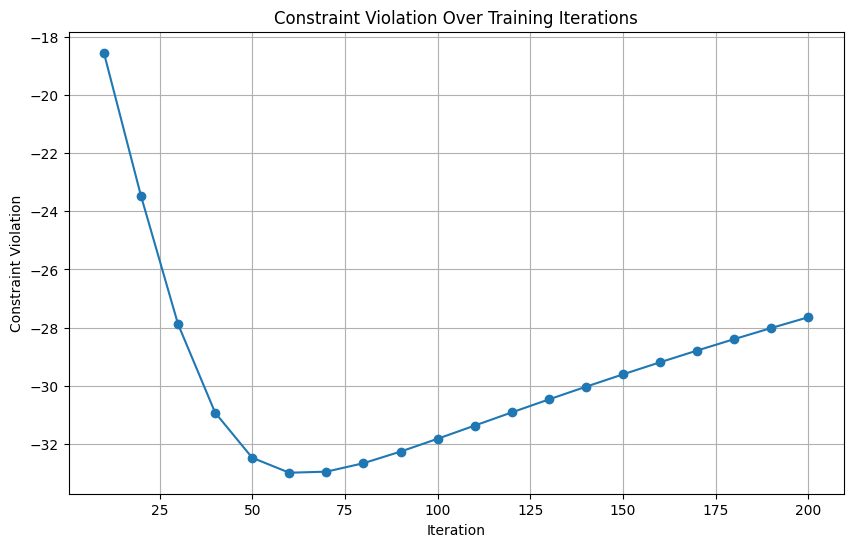

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

if 'constraint_violations_history' in globals() and 'iterations_history' in globals():
    if constraint_violations_history and iterations_history:
        plt.figure(figsize=(10, 6))
        plt.plot(iterations_history, constraint_violations_history, marker='o', linestyle='-')
        plt.title('Constraint Violation Over Training Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Constraint Violation')
        plt.grid(True)
        plt.show()
    else:
        print("Constraint violation history is empty. Please ensure constraints were used and training ran correctly.")
else:
    print("Constraint violation history not found. Please run the training cell first.")